In [1]:
from safetensors.torch import load_file
import torchvision
import json
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
with open("data_paths.json") as file:
    data_paths = json.load(file)

In [3]:
len(data_paths)

23095

In [4]:
# get one sample to explore the data
sample = data_paths[33]
print(sample.keys())


def params_to_dict(params_path: str) -> dict:
    with open(params_path) as file:
        params = file.readlines()
        params = [param.strip() for param in params if param.strip()]

    params_dict = {}
    # split first 12 parameters by first " "
    for param in params[:12]:
        key, value = param.split(" ", 1)
        params_dict[key.strip()] = value.strip()
    # split remaining parameters by "="
    for param in params[12:]:
        key, value = param.split("=")
        params_dict[key.strip()] = value.strip()
    return params_dict


params = params_to_dict(sample["parameters"])

for i, (key, value) in enumerate(params.items()):
    print(f"{i}; {key}: {value}")

dict_keys(['batch', 'image_id', 'GT', 'raw_images', 'parameters', 'integral_images', 'embeddings'])
0; img_GT: (0, 0, 35, 0.0, 1.57, 0)
1; img_1: (0, -5, 35, 0.0, 1.57, 0)
2; img_2: (0, -4, 35, 0.0, 1.57, 0)
3; img_3: (0, -3, 35, 0.0, 1.57, 0)
4; img_4: (0, -2, 35, 0.0, 1.57, 0)
5; img_5: (0, -1, 35, 0.0, 1.57, 0)
6; img_6: (0, 0, 35, 0.0, 1.57, 0)
7; img_7: (0, 1, 35, 0.0, 1.57, 0)
8; img_8: (0, 2, 35, 0.0, 1.57, 0)
9; img_9: (0, 3, 35, 0.0, 1.57, 0)
10; img_10: (0, 4, 35, 0.0, 1.57, 0)
11; img_11: (0, 5, 35, 0.0, 1.57, 0)
12; numbers of tree per ha: 100
13; person shape: laying
14; person pose (x,y,z,rot x, rot y, rot z): 5 -8 0 0 0 2.53073
15; person rotation (z) in radian: 2.530727415391778
16; person rotation (z) in degree: 145.0
17; ambient light: 0.5066601967691762
18; azimuth angle of sun light in degrees: 2.0
19; compass direction of sunlight in degrees: 211.0
20; ground surface temperature in kelvin: 283
21; tree top temperature in kelvin: 306


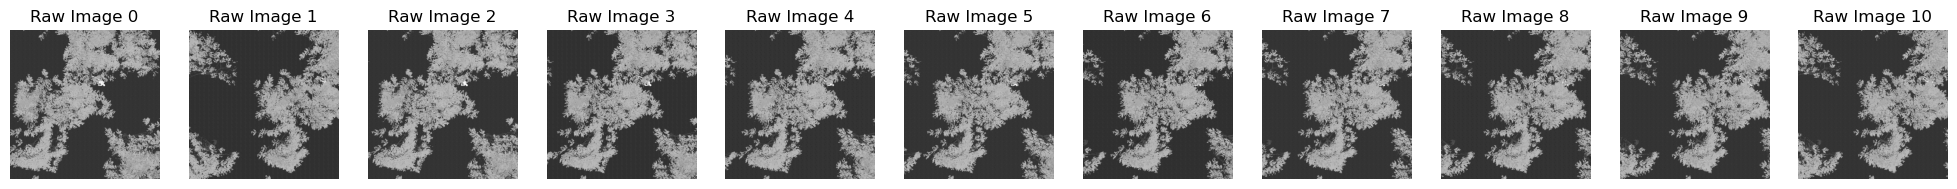

In [5]:
# plot raw images
fig, axs = plt.subplots(1, len(sample["raw_images"]), figsize=(25, 20))
for i, raw_image_path in enumerate(sample["raw_images"]):
    raw_image = torchvision.io.read_image(raw_image_path).permute(1, 2, 0)
    axs[i].imshow(raw_image, cmap="gray")
    axs[i].set_title(f"Raw Image {i}")
    axs[i].axis("off")
plt.show()

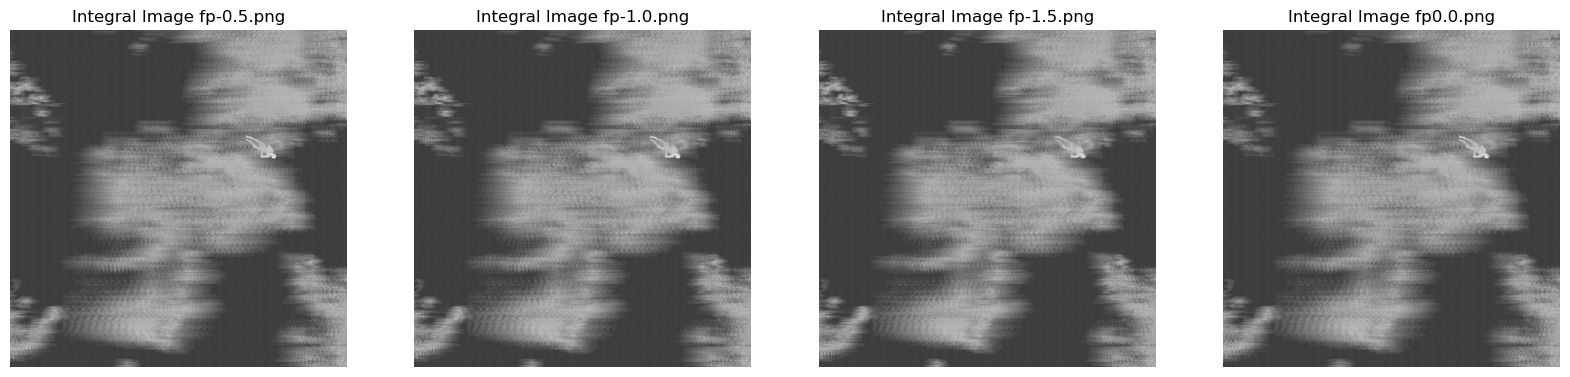

In [6]:
# plot integral images
fig, axs = plt.subplots(1, len(sample["integral_images"]), figsize=(20, 15))
for i, integral_image_path in enumerate(sample["integral_images"]):
    integral_image = torchvision.io.read_image(integral_image_path).permute(1, 2, 0)
    axs[i].imshow(integral_image, cmap="gray")
    axs[i].set_title(f"Integral Image {integral_image_path.split('_')[-1]}")
    axs[i].axis("off")
plt.show()

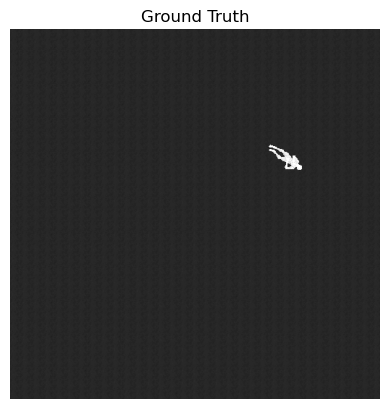

In [7]:
# plot gt image
gt_image = torchvision.io.read_image(sample["GT"]).permute(1, 2, 0)
plt.imshow(gt_image, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")
plt.show()

In [8]:
gt_image.squeeze()[:40,:40].unique()

tensor([56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], dtype=torch.uint8)

In [9]:
from safetensors.torch import load_file

embb = load_file(sample["embeddings"][0])
embb["last_hidden_states"].shape

torch.Size([1, 1297, 384])

# Poses

In [10]:
# get count of different poses
person_pose = defaultdict(int)

for paths in data_paths:
    params = params_to_dict(paths["parameters"])
    # different key pose has a different key if there is no person, but it's always the 14th key
    pose = params[list(params.keys())[13]]
    person_pose[pose] += 1
assert sum(person_pose.values()) == len(data_paths)
person_pose

defaultdict(int,
            {'laying': 6993, 'sitting': 6960, 'no person': 2234, 'idle': 6908})

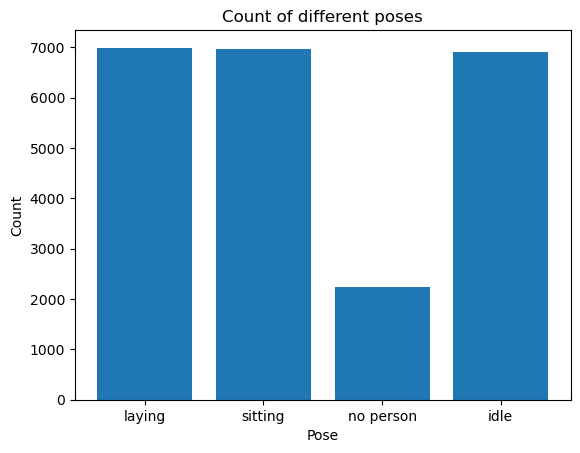

In [11]:
plt.bar(person_pose.keys(), person_pose.values())
plt.title("Count of different poses")
plt.xlabel("Pose")
plt.ylabel("Count")
plt.show()

In [12]:
person_pose["no person"] / (person_pose["laying"] + person_pose["sitting"] + person_pose["idle"])

0.10708978476583098

Only about 10% of the images have no person in them.

# Temperatures

In [13]:
stats = {
    "ground": [],
    "tree": [],
    "ambient light": [],
}
for data_path in data_paths:
    params = params_to_dict(data_path["parameters"])
    ground_temp = params["ground surface temperature in kelvin"]
    tree_temp = params["tree top temperature in kelvin"]
    ambient_light = params["ambient light"]
    stats["ground"].append(float(ground_temp))
    stats["tree"].append(float(tree_temp))
    stats["ambient light"].append(float(ambient_light))

assert len(stats["ground"]) == len(stats["tree"]) == len(stats["ambient light"]) == len(data_paths)

print(f"Ground Temps {set(stats['ground'])}")
print(f"Tree Temps {set(stats['tree'])}")
print(f"Ambient Light {set(stats['ambient light'])}")

Ground Temps {260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 287.0, 288.0, 289.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0, 296.0, 297.0, 298.0, 299.0, 300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306.0, 307.0, 308.0, 309.0, 310.0}
Tree Temps {295.0, 296.0, 297.0, 298.0, 299.0, 300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306.0, 307.0, 308.0, 309.0, 310.0, 311.0, 312.0}
Ambient Light {0.683324695902229, 0.5801571254161217, 0.8281326084164107, 0.9832051206288952, 0.8177429255383686, 0.7557105401757553, 0.8605242781897005, 0.9553527124510879, 0.9802403746192567, 0.5510114873973748, 0.5759186503291858, 0.9762080409563626, 0.9110292329768984, 0.8779791743282257, 0.8389126424127025, 0.5831284592709183, 0.5735413939351782, 0.9302443663148761, 0.7260478410180045, 0.6830656832338492, 0.579902942927447, 0.6759873072817301, 0.5996484180868721, 0.9611264697264233